In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

# WHO - global influenza occurences
The WHO reports Influenza occurences for all around the world on a weekly basis. It is expected that due to spreading patterns of influenza waves throughout the world, influenza waves different countries can be used as an indicator for the prediction of influenza waves for Germany. The data for the **Influenza transmission zone** South West Europe is analysed below 

Note: The influenza transmission zones join geographically related countries or territories to larger areas that have similar influenza transmission patterns so that an overview can be given. www.who.int/csr/.../swineflu/Influenza_Transmission_Zones.pdf


In [14]:
df_who_global = pd.read_csv('FluNetInteractiveReport.csv',skiprows=3,parse_dates=['SDATE','EDATE']).fillna(value = 0)
df_who_global.head()


,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,Albania,European Region of WHO,South West Europe,1997,1,1996-12-30,1997-01-05,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
1,Albania,European Region of WHO,South West Europe,1997,3,1997-01-13,1997-01-19,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
2,Albania,European Region of WHO,South West Europe,1997,16,1997-04-14,1997-04-20,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
3,Albania,European Region of WHO,South West Europe,1998,5,1998-01-26,1998-02-01,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report
4,Albania,European Region of WHO,South West Europe,1998,6,1998-02-02,1998-02-08,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report


['Country', 'WHOREGION', 'FLUREGION', 'Year', 'Week', 'SDATE', 'EDATE', 'SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB', 'AH1', 'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED', 'INF_A', 'BYAMAGATA', 'BVICTORIA', 'BNOTDETERMINED', 'INF_B', 'ALL_INF', 'ALL_INF2', 'TITLE']


Text(0,0.5,u'# of Influenza cases reported to WHO \n by individual countries')

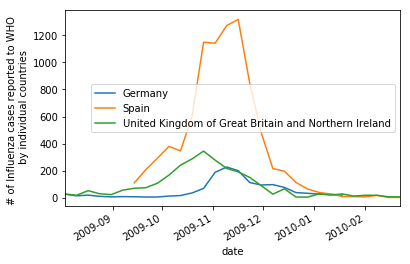

In [68]:
print(list(df_who_global))

start_date_plot='2009-08-01'
end_date_plot='2010-03-03'
countries=['United Kingdom of Great Britain and Northern Ireland','Germany','Spain']

df_2years_G_F_I = df_who_global.loc[df_who_global['Country'].isin(countries)&(df_who_global['SDATE']>=start_date_plot)&(df_who_global['EDATE']<=end_date_plot)]

df_2years_G_F_I.set_index('SDATE',inplace=True)
fig = plt.figure()
df_2years_G_F_I.groupby('Country')['ALL_INF'].plot(legend = True)

plt.xlabel('date')
plt.ylabel('# of Influenza cases reported to WHO \n by individual countries')

#plt.savefig('InfluenzaDetectionsOverTime_France_Germany_Italy.eps')


In [16]:
df_inf_per_state_full=df_who_global.pivot(index='EDATE', columns='Country', values='ALL_INF')
df_inf_per_state_full.rename(columns={'United Kingdom of Great Britain and Northern Ireland':'UK'}, inplace=True)

df_inf_per_state_full.index = pd.to_datetime(df_inf_per_state_full.index)

print(list(df_inf_per_state_full))
df_inf_per_state_full.tail()

['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Kazakhstan', 'Kosovo (in accordance with Security Council resolution 1244 (1999))', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Republic of Moldova', 'Romania', 'Russian Federation', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tajikistan', 'The former Yugoslav Republic of Macedonia', 'Turkey', 'Turkmenistan', 'Ukraine', 'UK', 'Uzbekistan']


Country,Albania,Armenia,Austria,Azerbaijan,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Spain,Sweden,Switzerland,Tajikistan,The former Yugoslav Republic of Macedonia,Turkey,Turkmenistan,Ukraine,UK,Uzbekistan
EDATE,,,,,,,,,,,,,,,,,,,,,
2018-01-21,35.0,19.0,482.0,NaN,0.0,8.0,NaN,97.0,195.0,8.0,...,1400.0,747.0,1017.0,0.0,1.0,224.0,NaN,9.0,3695.0,2.0
2018-01-28,47.0,18.0,650.0,0.0,0.0,36.0,NaN,123.0,201.0,4.0,...,1192.0,1116.0,1039.0,3.0,8.0,210.0,NaN,25.0,3542.0,2.0
2018-02-04,82.0,21.0,667.0,3.0,6.0,14.0,NaN,54.0,215.0,NaN,...,821.0,1522.0,598.0,1.0,13.0,100.0,NaN,37.0,3119.0,1.0
2018-02-11,71.0,24.0,742.0,11.0,11.0,NaN,NaN,39.0,199.0,NaN,...,738.0,1779.0,74.0,NaN,51.0,120.0,NaN,82.0,2508.0,3.0
2018-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## RKI - Influenza occurances in Germany

In this section, the data from Robert Koch Institute about activity of Influenza virus in Germany is analysed (https://survstat.rki.de/Content/Query/Create.aspx). The data are published on weekly basis from year 2001. Every year, samples from patients with influenza-like illness are investigated, which are sent by the sentinel network of general practitioners and paediatricians. Only direct detection of influenza virus is notifiable to RKI.
The data are available for all German states (as shown in the figure below), even a finer granularity is available (county level) but wont be used in this analysis.

In [71]:
df_RKI_states = pd.read_csv('RKI_INV_0418_season_comma.csv', sep=';',skiprows=1).fillna(value = 0)
df_RKI_states.set_index('enddate',inplace=True)
df_RKI_states.index = pd.to_datetime(df_RKI_states.index)
df_RKI_states['Germany_sum'] = df_RKI_states['Germany_sum'].astype(float)
#print(type(df_RKI_states.loc['2001-01-14','Bavaria']))
df_RKI_states=df_RKI_states.drop(['Season year and week (40)'], axis=1)
df_RKI_states

,Germany_sum,Baden-Wuerttemberg,Bavaria,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Lower Saxony,North Rhine-Westphalia,Rhineland-Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig-Holstein,Thuringia,Unknown
enddate,,,,,,,,,,,,,,,,,,
2001-01-07,7.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2001-01-14,15.0,0.0,0.0,1.0,2.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2001-01-21,55.0,1.0,4.0,0.0,10.0,0.0,0.0,0.0,6.0,2.0,9.0,2.0,0.0,13.0,2.0,3.0,3.0,0.0
2001-01-28,187.0,27.0,7.0,0.0,14.0,0.0,1.0,0.0,22.0,13.0,21.0,3.0,0.0,65.0,0.0,10.0,4.0,0.0
2001-02-04,460.0,63.0,32.0,59.0,40.0,0.0,3.0,7.0,24.0,42.0,13.0,4.0,0.0,138.0,17.0,2.0,16.0,0.0
2001-02-11,536.0,86.0,40.0,28.0,34.0,0.0,2.0,9.0,2.0,26.0,19.0,14.0,5.0,69.0,155.0,6.0,41.0,0.0
2001-02-18,405.0,64.0,61.0,23.0,16.0,0.0,1.0,10.0,7.0,31.0,12.0,34.0,2.0,74.0,45.0,10.0,15.0,0.0
2001-02-25,244.0,46.0,56.0,7.0,13.0,0.0,2.0,2.0,2.0,17.0,10.0,17.0,2.0,28.0,23.0,12.0,7.0,0.0
2001-03-04,234.0,20.0,35.0,5.0,5.0,0.0,0.0,14.0,0.0,2.0,6.0,45.0,0.0,24.0,6.0,11.0,61.0,0.0


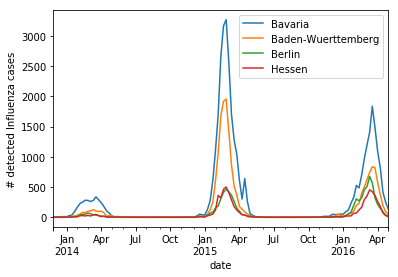

In [10]:
start_date_plot=datetime.datetime(2013,12,1)
end_date_plot=datetime.datetime(2016,5,4)

df_RKI_states.loc[start_date_plot:end_date_plot].plot(y=['Bavaria', 'Baden-Wuerttemberg', 'Berlin','Hessen'])
plt.xlabel('date')
plt.ylabel('# detected Influenza cases')
plt.legend()
plt.show()

The number of detected influenza cases reported by RKI with cases reported to WHO from Germany (both on weekly basis) are compared in the following. A significant discrepancy between these two quantities can be observed (the number of cases reported to WHO being significantly lower than detected cases reported on the RKI website). Additionally, a clear trend can be observed in both timeseries: while the number of cases reported to WHO is decreaseng in time, the number of influenza positive samples reported by RKI is increasing.

The dicrepansy between these sources of data was not investigated further, we decided to use the RKI data for the further analysis. Hoverer, the increasing trend in the RKI data needs to be explained: Does it reflect an increasing magnitude of flu waves in the recent years or just a higher detection of influenza viruses (through more samples investigated and recorded in the RKI database)?

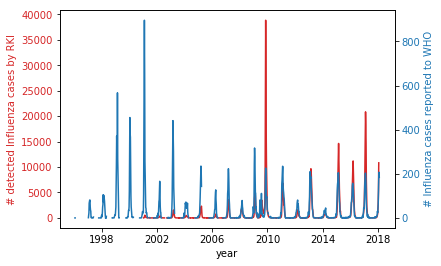

corr.coef: 0.465240036229


In [69]:
start_date_plot=datetime.datetime(1995,12,1)
end_date_plot=datetime.datetime(2018,3,23)

WHO_RKI=pd.DataFrame()
WHO_RKI['Germany WHO'] = df_inf_per_state_full.loc[start_date_plot:end_date_plot,'Germany']
WHO_RKI['Germany RKI']=df_RKI_states.loc[start_date_plot:end_date_plot,'Germany_sum']
#WHO_RKI.plot(secondary_y=['Germany WHO'])
#plt.xlabel('date')
#plt.ylabel('# detected Influenza cases')


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = 'tab:red'
ax1.plot(WHO_RKI.index, WHO_RKI['Germany RKI'], color=color)
ax1.set_xlabel('year')
ax1.set_ylabel('# detected Influenza cases by RKI', color=color)
ax1.tick_params(axis='y', labelcolor=color)


color = 'tab:blue'
ax2.plot(WHO_RKI.index, WHO_RKI['Germany WHO'], color=color)
ax2.set_ylabel('# Influenza cases reported to WHO', color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



print('corr.coef: ' + str(WHO_RKI['Germany RKI'].corr(WHO_RKI['Germany WHO'])))


The increasing trend in the RKI data (number of detected Influenza cases) needs to be explained: Does it reflect an increasing magnitude of flu waves in the recent years or just a higher detection of influenza viruses (through more samples investigated and recorded in the RKI database)? 

To clarify this, the RKI seasonal estimates of doctor visits associated with flu waves were investigated. These are considered to be the best available quantities for representation of the real magnitude of flu waves in Germany and, ultimately, for predicting the number of incoming flu-associated claims. 

RKI provides estimates of excess-doctor visits (Exzess-Konsultationen), excess hospitalisations (Exzess-Hospitalisierungen) and other summary statistics that can be associated with the influenza wave for each season within the Influenza season reports (https://influenza.rki.de/Saisonbericht.aspx). These data are only provided once per year after the end of the season and cannot thus be used for the real-time prediction. Note that the following data were extracted by hand from the reports and can thus be subject to human error. 

In [60]:
RKI_season_summary = pd.read_excel('RKI-Seasonal_reports_summary.xlsx',skiprows=1)
RKI_season_summary=RKI_season_summary.set_index('end_y')
RKI_season_summary.tail()

,Season,begin_w,begin_y,end_w,end_y,duration,peak_w,peak_y,peak_date,Exzess-Konsultationen,Exzess-Arbeitsunfaehigkeiten bzw. Pflegebeduerftigkeit bei Kindern und nicht Berufstaetigen,Exzess-Hospitalisierungen,Erkrankungen (aggregiert uebermittelte Faelle und Einzelfaelle):,Erkrankungen (Einzelfaelle),Hospitalisierungen,Todesfaelle,Todesfaelle with inf,Note
10,2012/13,50.0,2012.0,16.0,2013,18.0,8,2013,2013-02-21,7700000,4300000.0,32000.0,NaN,66000.0,10700.0,198.0,NaN,NaN
11,2013/14,8.0,2014.0,14.0,2014,6.0,12,2014,2014-03-20,780000,430000.0,3100.0,NaN,6200.0,1400.0,NaN,23.0,NaN
12,2014/15,2.0,2015.0,16.0,2015,14.0,7,2015,2015-02-12,6200000,3700000.0,31000.0,NaN,70000.0,11000.0,169.0,274.0,NaN
13,2015/16,2.0,2016.0,15.0,2016,13.0,10,2016,2016-03-10,4100000,2200000.0,16000.0,NaN,71000.0,13000.0,143.0,234.0,NaN
14,2016/17,51.0,2016.0,11.0,2017,12.0,5,2017,2017-02-02,5950000,3400000.0,30000.0,NaN,114000.0,26000.0,448.0,NaN,NaN


In the following, the correlation between doctor consultations ('Exzess-Konsultationen') and selected quantities are calculated and plotted. A very strong correlation with unability to work (Exzess-Arbeitsunfaehigkeiten) and hospitalisations can be observed. Also duration of the flu wave is positively correlated with the number of doctor consultations. 

In [61]:
df_corr_summary=pd.DataFrame(index=['corr_coef'])
check=['duration', 'end_w','Exzess-Arbeitsunfaehigkeiten bzw. Pflegebeduerftigkeit bei Kindern und nicht Berufstaetigen', 'Exzess-Hospitalisierungen']

i=0
for c in RKI_season_summary.loc[:,check]:
    df_corr_summary[check[i]]=RKI_season_summary.loc[:,'Exzess-Konsultationen'].corr(RKI_season_summary.loc[:,check[i]])
    i+=1

#RKI_season_summary.loc[:,'Exzess-Konsultationen'].corr(RKI_season_summary.loc[:,check[2]])
df_corr_summary

,duration,end_w,Exzess-Arbeitsunfaehigkeiten bzw. Pflegebeduerftigkeit bei Kindern und nicht Berufstaetigen,Exzess-Hospitalisierungen
corr_coef,0.681338,0.185581,0.981886,0.963863


corr.coef: 0.963862661256


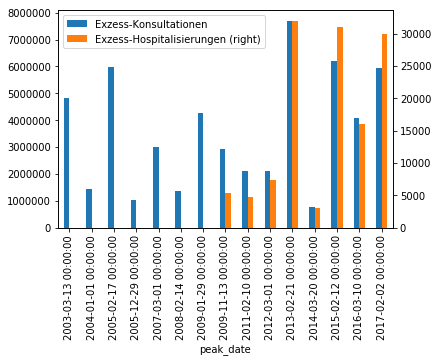

In [23]:
RKI_season_plot=RKI_season_summary.loc[:,['peak_date','Exzess-Konsultationen', 'Exzess-Hospitalisierungen']]
RKI_season_plot.set_index('peak_date',inplace=True)

RKI_season_plot.plot.bar(secondary_y=['Exzess-Hospitalisierungen'])

print('corr.coef: ' + str(RKI_season_plot['Exzess-Konsultationen'].corr(RKI_season_plot['Exzess-Hospitalisierungen'])))

Finally, the estimated number of consultations due to influenza ('Exzess-Konsultationen') and the number of detected influenza cases (on samples investigated in the laboratories) reported to RKI are compared. The increasing number of detected cases over time (plotted in blue bars) is not due to actual worsening of the flu waves (no trend can be observed in the red bars), but rather due to a higher detection rate (more samples investigated and reported to RKI). 

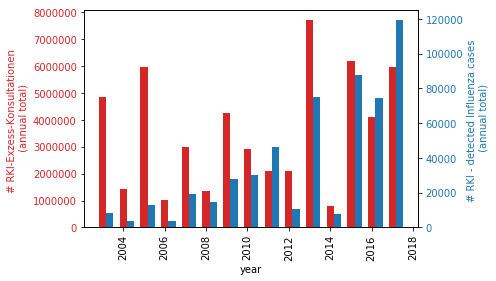

corr.coef: 0.663383848765


,RKI-Exzess-Konsultationen,RKI-detected influenza cases (from samples),detection rate
2003,4835000.0,8548.0,0.001768
2004,1445000.0,3763.0,0.002604
2005,5965000.0,12979.0,0.002176
2006,1030000.0,3729.0,0.003620
2007,3000000.0,19278.0,0.006426
2008,1355000.0,14431.0,0.010650
2009,4255000.0,28059.0,0.006594
2010,2930000.0,30193.0,0.010305
2011,2100000.0,46384.0,0.022088
2012,2100000.0,10703.0,0.005097


In [182]:
start_date_season=[12,1]
end_date_season=[4,30]

years_end=[str(e) for e in range(2003,2018,1)]

df_RKI_seasonsum=pd.DataFrame(index=years_end,columns=['RKI-Exzess-Konsultationen', 'RKI-detected influenza cases (from samples)', 'detection rate']).astype(float)
for y in years_end:
    start_date=datetime.datetime(int(y)-1,start_date_season[0],start_date_season[1])
    end_date=datetime.datetime(int(y),end_date_season[0],end_date_season[1])
    df_RKI_seasonsum.loc[y, 'RKI-Exzess-Konsultationen'] =RKI_season_summary.loc[int(y),'Exzess-Konsultationen']
    df_RKI_seasonsum.loc[y, 'RKI-detected influenza cases (from samples)'] =sum(df_RKI_states.loc[start_date:end_date,'Germany_sum'])
    df_RKI_seasonsum.loc[y, 'detection rate'] =df_RKI_seasonsum.loc[y, 'RKI-detected influenza cases (from samples)']/df_RKI_seasonsum.loc[y, 'RKI-Exzess-Konsultationen']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ind = df_RKI_seasonsum.index.astype(int)
width = 0.35

color = 'tab:red'
ax1.bar(ind, df_RKI_seasonsum['RKI-Exzess-Konsultationen'],width, color=color)
#ax1.set_xticks(years_end)
ax1.set_xlabel('year')
ax1.set_ylabel('# RKI-Exzess-Konsultationen \n (annual total)', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


color = 'tab:blue'
ax2.bar(ind+width, df_RKI_seasonsum['RKI-detected influenza cases (from samples)'],width , color=color)
ax2.set_ylabel('# RKI - detected Influenza cases \n (annual total)', color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()    
    
    
    
print('corr.coef: ' + str(df_RKI_seasonsum.loc[:, 'RKI-Exzess-Konsultationen'] .corr(df_RKI_seasonsum.loc[:, 'RKI-detected influenza cases (from samples)'])))    
df_RKI_seasonsum

The detection ratio (=RKI-detected influenza cases/RKI-Exzess-Konsultationen) more or less steadily increases form 0.002 in 2003 to 0.02 in 2017. 

Text(0,0.5,u'detection rate \n = detected cases / Exzess-Konsultationen')

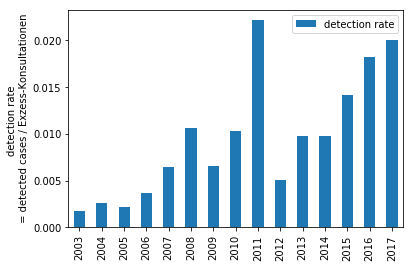

In [194]:
df_RKI_seasonsum.plot.bar(df_RKI_seasonsum.index,['detection rate'])
plt.ylabel('detection rate \n = detected cases / Exzess-Konsultationen')

It can be concluded, that the number of detected influenza cases, as reported by RKI on weekly basis, cannot be directly used as predictor for the number of doctor visits (and, ultimately, for prediction of number of claims) because the detection rate increases in time. Without taking into account the increasing detection rate, the magnitude of the future flu waves would likely be overestimated.

One could think about using the "praxis index" or "ARE-Konsultationen per 100000 Einwohner" for prediction, but they don't seem to be available in the required frequency and format by RKI. However, this might be further investigated as they obviously also collect this data on weekly basis... (query to RKI?)
https://influenza.rki.de/Diagrams.aspx?agiRegion=0

## Weather data

Wheather data from Deutscher Wetterdienst (DWD) available at (ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/daily/kl/historical/). Data from station München-Stadt were used for the analysis that are available from year 1954.

In [216]:
df_weather = pd.read_csv('produkt_klima_tag_19540601_20161231_03379.txt', sep=';')

df_weather=df_weather.set_index(['MESS_DATUM'])
df_weather.index = pd.to_datetime(df_weather.index, format='%Y%m%d')

df_weather.tail()


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
2016-12-27,3379,7,13.3,4.8,3,0.0,4,1.517,-999,5.8,5.5,975.96,2.7,74.21,4.2,0.8,-1.2,eor
2016-12-28,3379,7,9.7,3.0,3,0.0,0,1.800,-999,6.4,5.5,978.56,2.9,73.00,5.0,-1.4,-4.4,eor
2016-12-29,3379,7,6.8,2.0,3,0.0,0,6.667,-999,1.5,5.3,976.10,0.7,82.46,5.8,-2.4,-5.4,eor
2016-12-30,3379,7,3.8,1.4,3,0.0,4,5.617,-999,3.3,4.3,974.16,-3.6,92.67,-1.1,-5.3,-8.1,eor
2016-12-31,3379,7,2.8,1.1,3,0.0,4,6.900,-999,5.0,4.3,970.03,-3.5,91.33,2.1,-6.2,-6.0,eor


## Cross-correlation of influenza cases reported from European countries


In the following, the cross-correlation of the influenza cases reported in Germany and in other European countries is investigated for different time-lags, that may indicate the delay of the flu wave between the countries. 



In [14]:
#settings:

#time lags (in weeks) for calculating the cross-correlation
timelag=range(-5,10,1)

#cutoff year (from which year the analysis should be done)
cutoff=datetime.datetime(2008,1,1)
df_inf_per_state=df_inf_per_state_full.loc[cutoff:]
df_inf_per_state.head()

Country,Albania,Armenia,Austria,Azerbaijan,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,Spain,Sweden,Switzerland,Tajikistan,The former Yugoslav Republic of Macedonia,Turkey,Turkmenistan,Ukraine,UK,Uzbekistan
EDATE,,,,,,,,,,,,,,,,,,,,,
2008-01-06,NaN,NaN,NaN,NaN,NaN,34.0,NaN,0.0,7.0,NaN,...,65.0,25.0,13.0,NaN,NaN,NaN,NaN,0.0,67.0,NaN
2008-01-13,NaN,NaN,NaN,NaN,NaN,53.0,NaN,2.0,7.0,NaN,...,155.0,33.0,39.0,NaN,NaN,NaN,NaN,0.0,102.0,NaN
2008-01-20,NaN,NaN,NaN,NaN,0.0,64.0,NaN,7.0,12.0,NaN,...,159.0,28.0,23.0,NaN,NaN,NaN,NaN,0.0,68.0,NaN
2008-01-27,NaN,NaN,NaN,NaN,0.0,0.0,NaN,2.0,19.0,NaN,...,92.0,59.0,29.0,NaN,NaN,NaN,NaN,0.0,39.0,NaN
2008-02-03,NaN,NaN,NaN,NaN,0.0,91.0,NaN,4.0,19.0,NaN,...,4.0,68.0,26.0,NaN,NaN,NaN,NaN,5.0,40.0,NaN


In [15]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))   #pandas.Series.corr (Pearson correlation coefficient)

df_crosscorr=pd.DataFrame(index=timelag)
df_crosscorr_summary=pd.DataFrame(index=['max', 'shift [w]'])

for column in df_inf_per_state:
    xcov_weekly = [crosscorr(df_inf_per_state['Germany'],df_inf_per_state[column], lag=i) for i in timelag]
    df_crosscorr[column] = xcov_weekly
    df_crosscorr_summary[column]=[max(xcov_weekly), timelag[xcov_weekly.index(max(xcov_weekly))]]
 

df_crosscorr_summary.loc[:,['Italy','Austria','UK', 'Switzerland','France', 'Spain', 'Poland', 'Netherlands', 'Sweden']]


,Italy,Austria,UK,Switzerland,France,Spain,Poland,Netherlands,Sweden
max,0.594001,0.816064,0.608109,0.604847,0.82672,0.697308,0.624482,0.753514,0.729035
shift [w],1.000000,1.000000,4.000000,2.000000,2.00000,2.000000,0.000000,1.000000,0.000000


In [16]:

#df_crosscorr.reset_index().plot(x='index', y=['France', 'UK', 'Poland'])
#plt.xlabel('time lag [weeks]')
#plt.ylabel('crosscorrelation')
#plt.legend()
#plt.show()


Text(0.5,1,u'Poland')

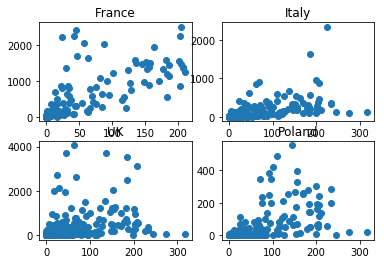

In [17]:
from datetime import timedelta

countries=['France','Italy','UK','Poland']
lag=0
d=datetime.timedelta(weeks=lag)

plt.subplot(221)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[0]])
plt.title(countries[0])

plt.subplot(222)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[1]])
plt.title(countries[1])

plt.subplot(223)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[2]])
plt.title(countries[2])

plt.subplot(224)
plt.scatter(df_inf_per_state.loc[(df_inf_per_state.index.min()+d):,'Germany'], df_inf_per_state.loc[:(df_inf_per_state.index.max()-d),countries[3]])
plt.title(countries[3])


EDATE
2008-01-06      3.0
2008-01-13     11.0
2008-01-20     18.0
2008-01-27     21.0
2008-02-03     41.0
2008-02-10     44.0
2008-02-17     57.0
2008-02-24     67.0
2008-03-02     79.0
2008-03-09     52.0
2008-03-16     43.0
2008-03-23     19.0
2008-03-30     18.0
2008-04-06     15.0
2008-04-13     10.0
2008-04-20      6.0
2008-04-27      9.0
2008-05-04      4.0
2008-05-11      1.0
2008-05-18      0.0
2008-05-25      0.0
2008-06-01      0.0
2008-06-08      0.0
2008-06-15      0.0
2008-06-22      1.0
2008-06-29      0.0
2008-07-06      0.0
2008-07-13      0.0
2008-07-20      0.0
2008-07-27      0.0
              ...  
2017-07-30      0.0
2017-08-06      1.0
2017-08-13      0.0
2017-08-20      0.0
2017-08-27      0.0
2017-09-03      0.0
2017-09-10      0.0
2017-09-17      0.0
2017-09-24      0.0
2017-10-01      NaN
2017-10-08      3.0
2017-10-15      5.0
2017-10-22      2.0
2017-10-29      0.0
2017-11-05      2.0
2017-11-12      3.0
2017-11-19      2.0
2017-11-26      6.0
2017-12-03    

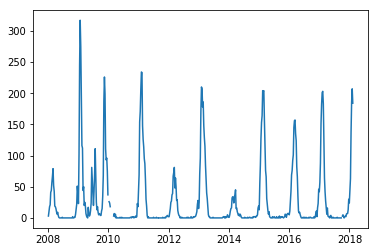

In [18]:
import numpy as np
from scipy import stats

x=df_inf_per_state.index.values
y=df_inf_per_state['Germany'].as_matrix()
not_nan_ind = ~np.isnan(y)
#m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
#detrend_y = y - (m*x + b)
plt.plot(x,y)

df_inf_per_state['Germany']

In [19]:
#detrending the data

from scipy import signal

df_inf_per_state_detr=pd.DataFrame()

x=df_inf_per_state.index.values

for column in df_inf_per_state:
    #df_inf_per_state_detr[column] = signal.detrend(df_inf_per_state[column])
    y=df_inf_per_state[column]
    not_nan_ind = ~np.isnan(y)
    m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
    detrend_y = y - (m*x + b)


signal.detrend(x)

TypeError: ufunc add cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

## Cross-correlation of influenza cases reported from German states


In the following, the cross-correlation of the influenza cases reported in Bavaria and in other states in Garmeny is investigated for different time-lags, that may indicate the delay of the flu wave between the states. 


In [20]:
#settings:

#time lags (in weeks) for calculating the cross-correlation
timelag=range(-5,10,1)

#cutoff year (from which year the analysis should be done)
cutoff=datetime.datetime(2000,1,1)
df_RKI_states=df_RKI_states.loc[cutoff:]
df_RKI_states.head()


,Germany_sum,Baden-Wuerttemberg,Bavaria,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Lower Saxony,North Rhine-Westphalia,Rhineland-Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig-Holstein,Thuringia,Unknown
enddate,,,,,,,,,,,,,,,,,,
2001-01-07,7.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2001-01-14,15.0,0.0,0.0,1.0,2.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2001-01-21,55.0,1.0,4.0,0.0,10.0,0.0,0.0,0.0,6.0,2.0,9.0,2.0,0.0,13.0,2.0,3.0,3.0,0.0
2001-01-28,187.0,27.0,7.0,0.0,14.0,0.0,1.0,0.0,22.0,13.0,21.0,3.0,0.0,65.0,0.0,10.0,4.0,0.0
2001-02-04,460.0,63.0,32.0,59.0,40.0,0.0,3.0,7.0,24.0,42.0,13.0,4.0,0.0,138.0,17.0,2.0,16.0,0.0


In [21]:
column

'Albania'

In [22]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))   #pandas.Series.corr (Pearson correlation coefficient)


df_crosscorrDE=pd.DataFrame(index=timelag)
df_crosscorrDE_summary=pd.DataFrame(index=['max', 'shift [w]'])

for column in df_RKI_states:
    xcov_weekly = [crosscorr(df_RKI_states['Bavaria'],df_RKI_states[column], lag=i) for i in timelag]
    df_crosscorrDE[column] = xcov_weekly
    df_crosscorrDE_summary[column]=[max(xcov_weekly), timelag[xcov_weekly.index(max(xcov_weekly))]]
 

df_crosscorrDE_summary

,Germany_sum,Baden-Wuerttemberg,Bavaria,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Mecklenburg-Vorpommern,Lower Saxony,North Rhine-Westphalia,Rhineland-Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig-Holstein,Thuringia,Unknown
max,0.963596,0.935987,1.0,0.886412,0.837059,0.757793,0.863888,0.932764,0.78603,0.868501,0.86036,0.930879,0.861642,0.823663,0.868402,0.916082,0.860269,0.668417
shift [w],-1.000000,0.000000,0.0,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


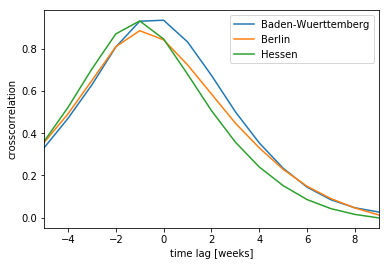

In [23]:
#plt.plot(timelag, df_crosscorr['France'])
df_crosscorrDE.reset_index().plot(x='index', y=['Baden-Wuerttemberg', 'Berlin', 'Hessen'])
plt.xlabel('time lag [weeks]')
plt.ylabel('crosscorrelation')
plt.legend()
plt.show()

Text(0.5,1,u'Bremen')

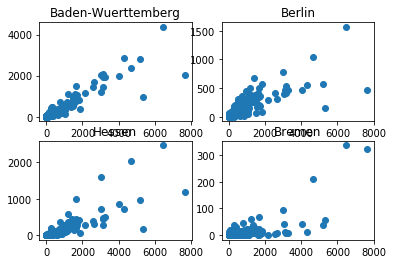

In [24]:
from datetime import timedelta

countries=['Baden-Wuerttemberg', 'Berlin', 'Hessen','Bremen']
lag=-1
d=datetime.timedelta(weeks=lag)

plt.subplot(221)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[0]])
plt.title(countries[0])

plt.subplot(222)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[1]])
plt.title(countries[1])

plt.subplot(223)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[2]])
plt.title(countries[2])

plt.subplot(224)
plt.scatter(df_RKI_states.loc[(df_RKI_states.index.min()+d):,'Bavaria'], df_RKI_states.loc[:(df_RKI_states.index.max()-d),countries[3]])
plt.title(countries[3])
 

# Google trend data

Google trend data is expected to give a good estimator of the current influenza situation in a country. It's quality for medium and long term are questionable. 

## Comparison Germany Bavaria (Saarland)

The google trend timeseries (keyword Influenza) from Germany and Bavaria (and Saarland) are superimposed to check wether different characteristics regarding initiation time/magnitude etc. can be observed.

In [28]:
# get data through the unofficial Google treds API (pytrends)
import pandas as pd
from pytrends.request import TrendReq
pytrends = TrendReq(hl = 'en-US')

kw_list = ["Influenza"]
timeframe_idx = 'today 5-y' # weekly stats for last 5 years (all givels everyting starting from 2004 but at monthly resolution)
cat_idx_Gesundheit = 45
geo_idx = 'DE'
geo_idxBY = 'DE-BY'
geo_idxSL = 'DE-SL'

pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = geo_idx)
pf_googleTrends_Germany = pytrends.interest_over_time()
pf_googleTrends_Germany.rename(columns={'Influenza':'Germany'})

pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = geo_idxBY)
pf_googleTrends_Bavaria = pytrends.interest_over_time()
pf_googleTrends_Bavaria.rename(columns={'Influenza':'Bavaria'})

pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = geo_idxSL)
pf_googleTrends_Saarland = pytrends.interest_over_time()
pf_googleTrends_Saarland.rename(columns={'Influenza':'Saarland'})

pf_googleTrends_EU = pf_googleTrends_Germany
pf_googleTrends_EU = pf_googleTrends_EU.rename(columns = {'Influenza':'Germany'})

EUcountries = {'Belgium':'BE','Bulgaria':'BG','Czech Republic':'CZ','Denmark':'DK','Estonia':'EE','Ireland':'IE','Greece':'GR','Spain':'ES','France':'FR','Croatia':'HR','Italy':'IT','Cyprus':'CY','Latvia':'LV','Lithuania':'LT','Luxembourg':'LU','Hungary':'HU','Netherlands':'NL','Austria':'AT','Poland':'PL','Portugal':'PT','Romania':'RO','Slovenia':'SI','Slovakia':'SK','Finland':'FI','Sweden':'SE','UK':'GB'}#,'Malta':'MT'}
Influenza_dictionary = {'Belgium':['Influenza'],'Bulgaria':['грип'],'Czech Republic':['chřipka'],'Denmark':['Influenza'],'Estonia':['gripp'],'Ireland':['influenza'],'Greece':['γρίπη'],'Spain':['influenza '],'France':['influenza '],'Croatia':['influenca'],'Italy':['influenza'],'Cyprus':['γρίπη'],'Latvia':'gripa','Lithuania':['gripą'],'Luxembourg':['influenza'],'Hungary':['influenza'],'Netherlands':['influenza'],'Austria':['Influenza'],'Poland':['grypa'],'Portugal':['influenza'],'Romania':['gripă'],'Slovenia':['gripe'],'Slovakia':['chrípka'],'Finland':['influenssa'],'Sweden':['influensa'],'UK':['influenza']}#,'Malta':['influwenza']}



for country_key in EUcountries.keys():
    print(country_key)
    kw_list = Influenza_dictionary[country_key]
    pytrends.build_payload(kw_list,cat=cat_idx_Gesundheit,timeframe = timeframe_idx,geo = EUcountries[country_key])
    temp_df = pytrends.interest_over_time().drop('isPartial',axis =1)
    temp_df = temp_df.rename(columns = {kw_list[0]:country_key})
    pf_googleTrends_EU = pf_googleTrends_EU.join(temp_df,rsuffix = EUcountries[country_key])



Italy
Czech Republic


/Users/olgaspackova/anaconda2/lib/python2.7/site-packages/dateutil/parser.py:98: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  while nextchar == '\x00':
/Users/olgaspackova/anaconda2/lib/python2.7/site-packages/dateutil/parser.py:123: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif nextchar == '.':


Lithuania
Luxembourg
France
Slovakia
Ireland
Slovenia
Belgium
Spain
Netherlands
Denmark
Poland
Finland
Sweden
Latvia
Croatia
Bulgaria
Romania
Estonia
Portugal
Austria
UK
Greece


/Users/olgaspackova/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1261: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


Hungary
Cyprus


In [29]:
pf_googleTrends_EU.tail(22)

,Germany,isPartial,Italy,Czech Republic,Lithuania,Luxembourg,France,Slovakia,Ireland,Slovenia,...,Croatia,Bulgaria,Romania,Estonia,Portugal,Austria,UK,Greece,Hungary,Cyprus
date,,,,,,,,,,,,,,,,,,,,,
2017-09-24,6,False,13,16,0,0,37,26,4,0,...,0,7,0,21,0,7,31,9,5,0
2017-10-01,5,False,13,19,0,0,14,4,18,13,...,0,22,0,10,13,4,32,0,5,0
2017-10-08,8,False,13,10,0,0,45,17,29,13,...,0,9,0,10,13,7,30,0,8,0
2017-10-15,6,False,12,15,0,0,18,8,14,13,...,0,19,0,10,51,7,24,0,8,0
2017-10-22,7,False,11,9,0,0,69,8,7,0,...,0,13,0,0,13,4,23,0,14,0
2017-10-29,6,False,12,10,0,0,37,0,11,14,...,0,5,0,10,39,6,30,0,10,0
2017-11-05,5,False,17,12,0,11,54,4,21,0,...,0,10,0,0,0,4,29,10,13,0
2017-11-12,8,False,14,8,0,0,40,15,4,12,...,0,16,0,0,65,4,36,28,11,0
2017-11-19,7,False,14,12,0,0,22,11,7,12,...,0,9,0,10,38,11,25,0,17,0


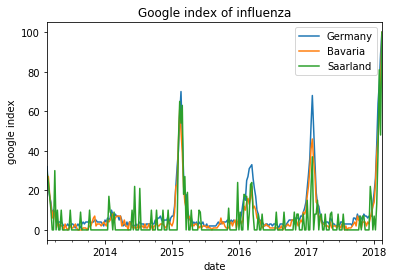

In [30]:
fig = plt.figure()
ax = pf_googleTrends_Germany.plot()
pf_googleTrends_Bavaria.plot(ax = ax)
pf_googleTrends_Saarland.plot(ax = ax)

plt.title('Google index of influenza')
plt.xlabel('date')
plt.ylabel('google index')
ax.legend(['Germany','Bavaria','Saarland'])





## Autocorrelation Germany

/Users/olgaspackova/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 60)

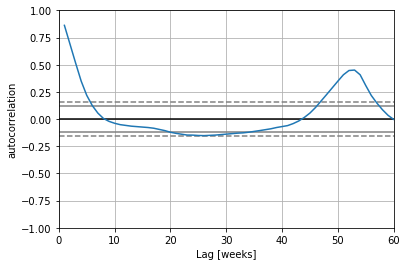

In [31]:
from pandas.tools.plotting import autocorrelation_plot
fig = plt.figure()
autocorrelation_plot(pf_googleTrends_Germany['Influenza'])
plt.xlabel('Lag [weeks]')
plt.ylabel('autocorrelation')
plt.xlim([0,60])

## Cross-correlation of influenza cases reported from European countries with Google trend data

In [ ]:
# get worldwide google Influenza trends 
# get data through the unofficial Google treds API (pytrends)


In [32]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))   #pandas.Series.corr (Pearson correlation coefficient)


timelag=range(-5,10,1)

df_crosscorr_google=pd.DataFrame(index=timelag)
df_crosscorr_google_summary=pd.DataFrame(index=['max', 'shift [w]'])

for column in EUcountries.keys():
    xcov_weekly = [crosscorr(pf_googleTrends_EU['Germany'],pf_googleTrends_EU[column], lag=i) for i in timelag]
    df_crosscorr_google[column] = xcov_weekly
    df_crosscorr_google_summary[column]=[max(xcov_weekly), timelag[xcov_weekly.index(max(xcov_weekly))]]
 

df_crosscorr_google_summary.loc[:,['Italy','Austria','UK', 'Switzerland','France', 'Spain', 'Poland', 'Netherlands', 'Sweden']]#EUcountries.keys()]#]


,Italy,Austria,UK,Switzerland,France,Spain,Poland,Netherlands,Sweden
max,0.902937,0.876468,0.730095,NaN,0.575316,0.534779,0.529252,0.750738,0.803877
shift [w],5.000000,2.000000,4.000000,NaN,4.000000,4.000000,2.000000,2.000000,0.000000


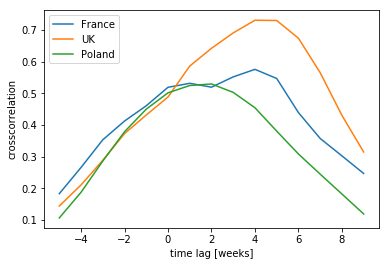

In [66]:
df_crosscorr_google.reset_index().plot(x='index', y=['France', 'UK', 'Poland'])
plt.xlabel('time lag [weeks]')
plt.ylabel('crosscorrelation')
plt.legend()
plt.show()


## Comparison of magnitude between different countries
To use the data from other countries for prediction of the magnitude of the flu wave in Germany there needs to be a clear relationship between the magnitudes of the flu waves (here in terms of google search index) in the different countries.

(2401, 2513)

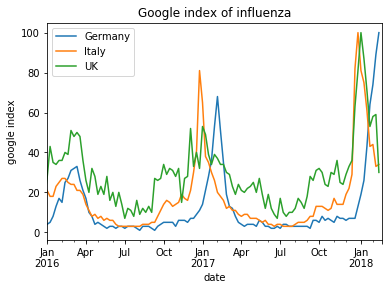

In [67]:
fig = plt.figure()

countries = ['Germany','Italy','UK']#,'France','Poland']

for country in countries:
    ax_google = pf_googleTrends_EU[country].plot()
    pf_googleTrends_EU[country].plot(ax = ax)


plt.title('Google index of influenza')
plt.xlabel('date')
plt.ylabel('google index')
ax_google.legend(countries)
plt.xlim([datetime.date(year=2016,month=1,day=1),datetime.date.today()])





# Heatmaps

Heatmap created following: http://www.alexschultz.co.uk/weblog/2010/07/creating-country-level-heatmaps-in-python.html

In [68]:
os.getcwd()


NameError: name 'os' is not defined

In [ ]:
from lxml import etree
import os

def show_flu_inEU_for_week_lxml(date): 
    # date is a datetime object
    # soup a beatiful soup object
    currnt_dir = os.getcwd()
    os.chdir(currnt_dir)
    svg = etree.parse('Blank_map_of_Europe_cropped.svg')
    EUcountries = {'Belgium':'BE','Bulgaria':'BG','Czech Republic':'CZ','Denmark':'DK','Estonia':'EE','Ireland':'IE','Greece':'GR','Spain':'ES','France':'FR','Croatia':'HR','Italy':'IT','Cyprus':'CY','Latvia':'LV','Lithuania':'LT','Luxembourg':'LU','Hungary':'HU','Netherlands':'NL','Austria':'AT','Poland':'PL','Portugal':'PT','Romania':'RO','Slovenia':'SI','Slovakia':'SK','Finland':'FI','Sweden':'SE','UK':'GB'}#,'Malta':'MT'}
    map_countryCode = {'lt-3': 'Lithuania', 'gb-gbn-5': 'UK', 'lv-1': 'Latvia', 'fi-5': 'Finland', 'sk-2': 'Slovakia', 'lu-7': 'Luxembourg', 'si-9': 'Slovenia', 'at-3': 'Austria', 'ie-5': 'Ireland', 'dk-9': 'Denmark', 'be-2': 'Belgium', 'gr-7': 'Greece', 'ee-8': 'Estonia', 'es-4': 'Spain', 'cz-1': 'Czech Republic', 'ro-1': 'Romania', 'hu-3': 'Hungary', 'nl-3': 'Netherlands', 'hr-2': 'Croatia', 'it-4': 'Italy', 'cy-6': 'Cyprus', 'fr-7': 'France', 'pt-0': 'Portugal', 'se-7': 'Sweden', 'de-2': 'Germany', 'bg-3': 'Bulgaria', 'pl-1': 'Poland'}#, 'mt-0': 'Malta'}
#    map_countryCode = {'lt': 'Lithuania', 'gb': 'UK', 'lv': 'Latvia', 'fi': 'Finland', 'sk': 'Slovakia', 'lu': 'Luxembourg', 'si': 'Slovenia', 'at': 'Austria', 'ie': 'Ireland', 'dk': 'Denmark', 'be': 'Belgium', 'gr': 'Greece', 'va': 'Vatican', 'ee': 'Estonia', 'es': 'Spain', 'cz': 'Czech Republic', 'ro': 'Romania', 'mt': 'Malta', 'hu': 'Hungary', 'nl': 'Netherlands', 'hr': 'Croatia', 'it': 'Italy', 'cy': 'Cyprus', 'fr': 'France', 'pt': 'Portugal', 'se': 'Sweden', 'de': 'Germany', 'bg': 'Bulgaria', 'pl': 'Poland'}
    
    path_style ="stroke:#ffffff;stroke-width:0.40082097;stroke-miterlimit:4;stroke-dasharray:none;fill:" 
    #path_style = "fill-opacity:1;stroke:#ffffff;stroke-width:0.5225144" 
    colormap = ["#c0c0c0","#ffeda0","#feb24c","#f03b20"]

    pf_of_date = pf_googleTrends_EU.ix[date]
    root = svg.getroot()
    child_element = root.find('{http://www.w3.org/2000/svg}g')
    # countries with multiple polygons
    gs = child_element.findall('{http://www.w3.org/2000/svg}g')
    
    # countries without multiple polygons
    paths = child_element.findall('{http://www.w3.org/2000/svg}path')
    
    for p in paths:
        p_id = p.get('id')
        
        if p_id in map_countryCode.keys():
            if pf_of_date[map_countryCode[p_id]] > 50:
                color_class = 3
            elif pf_of_date[map_countryCode[p_id]] > 10:
                color_class = 2               
            elif pf_of_date[map_countryCode[p_id]] > 1:
                color_class = 1                  
            else:
                color_class = 0
              
            color = colormap[color_class]
            p.set('style', path_style + color)
            
            
            
    for g in gs:
        g_id = g.get('id')
        if g_id in map_countryCode.keys():        
            if pf_of_date[map_countryCode[g_id]] > 50:
                color_class = 3
            elif pf_of_date[map_countryCode[g_id]] > 10:
                color_class = 2
            elif pf_of_date[map_countryCode[g_id]] > 1:
                color_class = 1
            else:
                color_class = 0
            color = colormap[color_class]  
            
            for t in g.findall('{http://www.w3.org/2000/svg}path'):
                t.set('style',path_style+color)
            for g_3rdlevel in g.findall('{http://www.w3.org/2000/svg}g'):
                for t2 in g_3rdlevel.findall('{http://www.w3.org/2000/svg}path'):
                    t.set('style',path_style+color)
                
    # write everything to a file
    f = svg.write('EU_flu_'+ date.strftime('%Y_%m_%d')+'.svg',pretty_print = True)            
                        
        

In [ ]:
startdate = datetime.datetime.strptime('2017-07-30','%Y-%m-%d')
time_steps = 12
time_delta = 14 #days

for i in xrange(0,time_steps):
    date = startdate + timedelta(days= i*time_delta)
    show_flu_inEU_for_week_lxml(date)


new cell